In [45]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim as optim
from torch.autograd import Variable
import numpy.random as rand
import numpy as np
import sys
import os
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import



from bnn import BNNBayesbyBackprop, gauss_logpdf
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/emerson/programming/BDL_final_project'

## Toy dataset for regression

In [3]:
W = np.array([-10, 10]).reshape(-1, 1)
b = -5
X_train = np.random.uniform(-10,10, (5000, 2))
X_train[:,0] = 0.0
X_train.shape
W.T.shape

eps = 0.0001
W_s = np.array([0.0, 0.3]).reshape(-1, 1)
print(W_s)
b_s = 0.1

print(b_s)

y_train = np.zeros((X_train.shape[0], 1), dtype=float)
for ind, x in enumerate(X_train):
  # y_train[ind] = x @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
  y_train[ind] = x.reshape(1,-1) @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))



print(y_train)

[[0. ]
 [0.3]]
0.1
[[-52.82162314]
 [  4.27946549]
 [ 38.75353933]
 ...
 [-99.47149931]
 [-88.35922307]
 [ -1.66536826]]


(array([626., 663., 630., 624., 608., 611., 675., 394., 145.,  24.]),
 array([-105.03653382,  -80.23105825,  -55.42558268,  -30.62010711,
          -5.81463154,   18.99084403,   43.7963196 ,   68.60179517,
          93.40727074,  118.21274631,  143.01822188]),
 <a list of 10 Patch objects>)

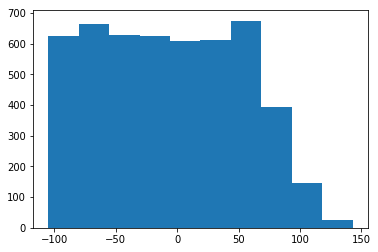

In [4]:
plt.hist(y_train)
# np.exp(10 * 0.01)

compare likelihood of test set given true mean and true variance and true variance + bias

In [5]:
tst = np.empty_like(X_train[:,0])
for ind, x in enumerate(X_train):
  # y_train[ind] = x @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
  tst[ind] = x.reshape(1,-1) @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
tst

print(gauss_logpdf(tst, X_train @ W + b, np.exp(x @ W_s + b_s)).sum())
print(gauss_logpdf(tst, X_train @ W + b, np.exp(x @ W_s + b_s) + 100).sum())

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

Toy dataset for classification 2d

In [6]:
dataset_size = 5000

X_train = np.empty(shape=(dataset_size, 2), dtype=float)
y_train = np.empty(shape=(dataset_size,), dtype=float)

# make first dimension 0 to effectively make it univariate 
# bc current bnn arch only works with multivariate input
X_train[:int(dataset_size/2),0] = np.random.normal(loc=0,
                                                   scale=1,
                                                   size=(int(dataset_size/2),))
X_train[:int(dataset_size/2), 1] = np.random.normal(loc=-5, 
                                                    scale=1, 
                                                    size=(int(dataset_size/2),))
y_train[:int(dataset_size/2)] = 0

X_train[int(dataset_size/2):,0] = np.random.normal(loc=0,
                                                   scale=1,
                                                   size=(int(dataset_size/2),))
X_train[int(dataset_size/2):, 1] = np.random.normal(loc=5,
                                                    scale=1,
                                                    size=(int(dataset_size/2),))
y_train[int(dataset_size/2):] = 1

# shuffle order
perm = np.random.permutation(dataset_size)
X_train = X_train[perm]
y_train = y_train[perm]

X shape (320, 320)
------


/home/emerson/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


NameError: name 'x_line' is not defined

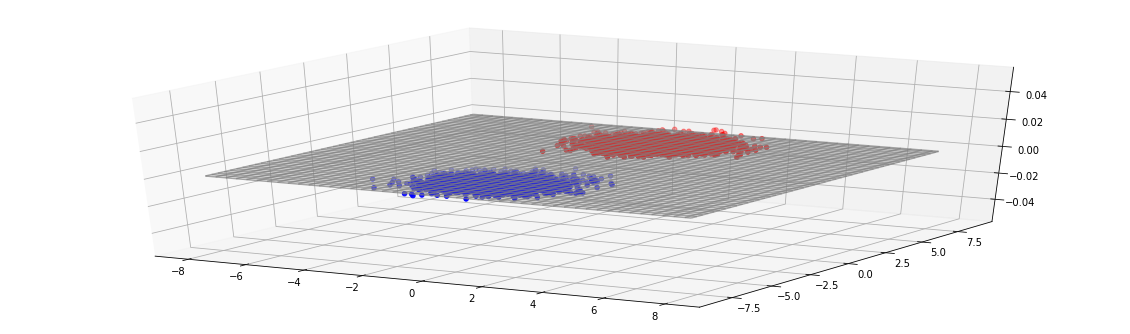

In [7]:
def plane(x1, x2, w1, b):
    return w1[0] * x1 + w1[1] * x2 + b
    

w1 = np.array([[0,0]]).T
w2 = np.array([[0,0]]).T
W_full = np.hstack((w1, w2))
b = 0

x = y = np.arange(-8.0, 8.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = plane(X, Y, w1, b)
print("X shape", zs.shape)

# Z = zs.reshape(X.shape)

# ax.plot_surface(X, Y, Z)

# x_line = np.random.uniform(-8, 8, (100, 2))
#  = 
# print(w1.T.shape)
# y = w1.T @ x + b
# y = y.flatten()
# plt.plot(x1, x2)
# plt.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='red', alpha=0.2)
# plt.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='blue', alpha=0.2)
# plt.ylim((-10, 10))


fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(311, projection='3d')       
ax.plot_wireframe(X, Y, zs, color='grey', alpha = 0.7)
ax.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='blue')
ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='red')
fig.show()
print("------")                                                        
print(x_line[:,0].shape)                                                   
print(x_line[:,1].shape)                                                   
print(y.shape)                                                        
print("------")


# ax.scatter(X1_train_grd, X2_train_grd, alpha=0.5)

# ax.plot()
# ax.set_xlabel('X_train[:,0]')                                          
# ax.set_ylabel('X_train[:,1]')                                          
# ax.set_zlabel('output[:,1] (Standard Deviation)')                      
fig.show()
# plt.show()



Toy dataset for classification 1d

In [ ]:
dataset_size = 5000

X_train = np.empty(shape=(dataset_size, 2), dtype=float)
y_train = np.empty(shape=(dataset_size,), dtype=float)

# make first dimension 0 to effectively make it univariate 
# bc current bnn arch only works with multivariate input
X_train[:int(dataset_size/2), 0] = 0
X_train[:int(dataset_size/2), 1] = np.random.normal(loc=4,
                                                 scale=1,
                                                 size=(int(dataset_size/2),))
y_train[:int(dataset_size/2)] = 0

X_train[int(dataset_size/2):, 0] = 0
X_train[int(dataset_size/2):, 1] = np.random.normal(loc=14,
                                                   scale=1,
                                                   size=(int(dataset_size/2),))
y_train[int(dataset_size/2):] = 1

# shuffle order
perm = np.random.permutation(dataset_size)
X_train = X_train[perm]
y_train = y_train[perm]

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

In [ ]:
# a separating line!
# x1 = np.linspace(-2, 14, 20)
# y = x1 * 1 - 8.5

plt.scatter(X_train[y_train == 0, 1], [0]*int(X_train.shape[0]/2))
plt.scatter(X_train[y_train == 1, 1], [0]*int(X_train.shape[0]/2))
# plt.plot(x1, y)

In [ ]:
# W_full
# W
# preset_preds.shape
# print('MAE of BNN with q mean == true weights: ', np.mean(np.abs(preset_preds - y_train.flatten())))
# print('acc of BNN with q mean == true weights: ', np.mean((preset_preds == y_train.flatten()).astype(int)))
# print('\n')
# print(preset_preds[1], y_train[1])
# bnn_preset.model.l1.W_log_s_DO
# bnn_preset.model.l1.b_log_s_O
# bnn_preset.MC_elbo(torch.Tensor(X_train), torch.Tensor(y_train), 9, 10, 100).detach().numpy()

# plt.title("line with {} as slope".format(w))
# plt.plot(x1, x2)
# plt.scatter(X_train1[y_train1 == 0,0], X_train1[y_train1 == 0,1], c='red', alpha=0.2)
# plt.scatter(X_train1[y_train1 == 1,0], X_train1[y_train1 == 1,1], c='blue', alpha=0.2)
# plt.ylim((-10, 10))

# ax = fig.add_subplot(311, projection='3d')                             
# print("------")                                                        
# print(x1[:,0].shape)                                                   
# print(x1[:,1].shape)                                                   
# print(y1.shape)                                                        
# print("------")                                                        
# ax.plot_surface(x1[0,1], x1[:,1], y1)                                       
# ax.set_xlabel('X_train[:,0]')                                          
# ax.set_ylabel('X_train[:,1]')                                          
# ax.set_zlabel('output[:,1] (Standard Deviation)')                      
# fig.show()
# plt.show()



## test ELBO as slope of line changes

In [ ]:
def plane(x1, x2, w1, b):
    return w1[0] * x1 + w1[1] * x2 + b

# for regression toy set
# W_full = np.hstack((W, W_s))
# W_full

# b_full = np.hstack((b, b_s))
# b_full[1] = 2.0

# for 3d
# w1 = np.array([[0.0,1.0]]).T
# w2 = np.array([[0.0,0.0]]).T
# W_full = np.hstack((w1, w2))

# x1 = x2 = np.arange(-8.0, 8.0, 0.05)
# X1, X2 = np.meshgrid(x, y)
# b = 0
# Z = plane(X1, X2, w1, b)


w1 = np.array([[0.0,1.0]]).T
w2 = np.array([[0.0,0.0]]).T
W_full = np.hstack((w1, w2))
print(W_full)
print(w1)
# x1 = x2 = np.arange(-8.0, 8.0, 0.05)
# X1, X2 = np.meshgrid(x, y)
# b = 0
# Z = plane(X1, X2, w1, b)
bs = [i for i in range(-20, 20)]
used_bs = []
accuracies = []
x_ints = []
likelihoods = []
grad_bs = []
for b in bs:
    b_full = np.array([b,0])
    # b_full[0], b_full[1] = 0,0
    bnn_preset = BNNBayesbyBackprop(prior_mu=0, 
                                    prior_s=0.8, 
                                    linear_regression=True, 
                                    classification=True,
                                    preset={'W_mu': W_full, 'b_mu': b_full})
    preset_preds = bnn_preset.model.forward(torch.Tensor(X_train), predict=True).detach().numpy()
    used_b = bnn_preset.model.l1.usedBias[0].detach().numpy()
    used_w = bnn_preset.model.l1.usedWeights[:,0][1].detach().numpy()
    used_bs.append(used_b)
    
    x_intercept = -used_b / used_w
    x_ints.append(x_intercept)
    print('X_int', x_intercept)
    print('\nused_b is', used_b)
    print('used_w is ', used_w)
    
    bnn_preset.MC_elbo(torch.Tensor(X_train), torch.Tensor(y_train), 9, 10, 100).detach().numpy()
    acc = np.mean((preset_preds == y_train.flatten()).astype(int)) * 100
    accuracies.append(acc)
    print('Accuracy with {} as bias: '.format(b), acc, '%')
    
    likelihood = bnn_preset.mean_likelihood
    likelihoods.append(likelihood)
    print('likelihood', likelihood)
    
    grad_bs.append(bnn_preset.gradB)
 
fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True)
ax[0].plot(x_ints, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')

# ax[0].scatter([np.min(X_train[y_train == 1, 1]), np.max(X_train[y_train == 1, 1])], [50,50], c='red')


ax[1].plot(x_ints, likelihoods)
print('class 0 min: ', np.min(X_train[y_train == 0, 1]))
print('class 0 max: ',np.max(X_train[y_train == 0, 1]))
print('class 1 min: ', np.min(X_train[y_train == 1, 1]))
print('class 1 max: ',np.max(X_train[y_train == 1, 1]))



In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10,9), sharex=True)
ax[0].set_title('Accuracy v X-intercept')
ax[0].plot(x_ints, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')
ax[1].set_title('Likelihood v X-intercept')
ax[1].plot(x_ints, likelihoods)

ax[2].set_title('b grad v X-intercept')
ax[2].plot(x_ints, grad_bs)

NameError: name 'used_bs' is not defined

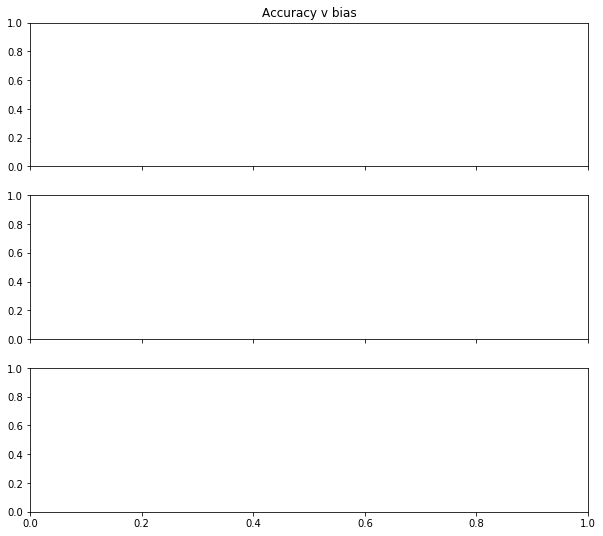

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(10,9), sharex=True)
ax[0].set_title('Accuracy v bias')
ax[0].plot(used_bs, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
# ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
# ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

# ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
# ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')
ax[1].set_title('Likelihood v bias')
ax[1].plot(used_bs, likelihoods)

ax[2].set_title('b grad v bias')
ax[2].plot(used_bs, grad_bs)

In [9]:
X_train1 = X_train
y_train1 = y_train

accuracies = []
weights = [0.0, 0.1, 0.5, 1.0, 3.0, 5.0, 5.5, 6.0, 7.0, 10.0]
for w in weights:
#     w1 = np.array([0, w])
    W_full[0][0] = w
    print('weights: ', W_full[0])
    bnn_preset = BNNBayesbyBackprop(prior_mu=0, 
                                prior_s=0.8, 
                                linear_regression=True, 
                                classification=True,
                                preset={'W_mu': W_full, 'b_mu': b_full})
    preset_preds = bnn_preset.model.forward(torch.Tensor(X_train1), predict=True).detach().numpy()
    print('ELBO components with {} as slope: \n'.format(w))
    bnn_preset.MC_elbo(torch.Tensor(X_train1), torch.Tensor(y_train1), 9, 10, 100).detach().numpy()
    print('Accuracy with {} as slope: '.format(w), np.mean((preset_preds == y_train1.flatten()).astype(int)) * 100, '%')
    
    Z = plane(X1, X2, W_full[0], b)
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(311, projection='3d') 
    ax.set_title("line with {} as slope".format(w))

    ax.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='blue')
    ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='red')
    ax.plot_wireframe(X1, X2, Z, color='grey', alpha = 0.99)

#     fig.show()
    plt.show()
#     x1 = np.random.uniform(-8, 8, 100)
#     x2 = w * x1

#     plt.title("line with {} as slope".format(w))
#     plt.plot(x1, x2)
#     plt.scatter(X_train1[y_train1 == 0,0], X_train1[y_train1 == 0,1], c='red', alpha=0.2)
#     plt.scatter(X_train1[y_train1 == 1,0], X_train1[y_train1 == 1,1], c='blue', alpha=0.2)
#     plt.ylim((-10, 10))
    

weights:  [0 0]


NameError: name 'b_full' is not defined

In [ ]:
# bnn = BNNBayesbyBackprop(prior_mu=0, prior_s=0.8, num_MC_samples=30, linear_regression=True, preset=False, classification=False)
# w1 = np.array([[0.0, 1.0]]).T
# w2 = np.array([[0.0, 0.0]]).T
# W_full = np.hstack((w1, w2))
# b_full = np.array([0,0])
# print(W_full)

bnn = BNNBayesbyBackprop(prior_mu=0.0, prior_s=1.0, num_MC_samples=30, linear_regression=True, preset=False, classification=True)
bnn.fit(X_train, y_train, plot=True, n_epochs=75, learning_rate=1e-2, batch_size=1000)

Data being saved in following file:
logging.csv
real:  [0. 0. 0. 1. 1. 1. 1.]
Epoch:  0 	Loss:  11837.227 	acc:  1.0 

real:  [0. 0. 0. 1. 1. 1. 1.]
Epoch:  1 	Loss:  8587.01 	acc:  0.0326 

real:  [0. 0. 0. 1. 1. 1. 1.]
Epoch:  2 	Loss:  6336.2314 	acc:  0.9532 

real:  [0. 0. 0. 1. 1. 1. 1.]
Epoch:  3 	Loss:  7224.2197 	acc:  0.7924 

real:  [0. 0. 0. 1. 1. 1. 1.]
Epoch:  4 	Loss:  5246.4546 	acc:  0.0082 

real:  [0. 0. 0. 1. 1. 1. 1.]
Epoch:  5 	Loss:  4908.7593 	acc:  0.9606 

real:  [0. 0. 0. 1. 1. 1. 1.]
Epoch:  6 	Loss:  4138.1436 	acc:  1.0 

real:  [0. 0. 0. 1. 1. 1. 1.]
Epoch:  7 	Loss:  4804.8115 	acc:  1.0 

real:  [0. 0. 0. 1. 1. 1. 1.]
Epoch:  8 	Loss:  4131.7896 	acc:  0.9982 

real:  [0. 0. 0. 1. 1. 1. 1.]
Epoch:  9 	Loss:  2453.8247 	acc:  0.9978 

real:  [0. 0. 0. 1. 1. 1. 1.]
Epoch:  10 	Loss:  2845.7637 	acc:  0.9766 

real:  [0. 0. 0. 1. 1. 1. 1.]
Epoch:  11 	Loss:  2526.548 	acc:  1.0 

real:  [0. 0. 0. 1. 1. 1. 1.]
Epoch:  12 	Loss:  1946.5447 	acc:  0.8286 

re

In [ ]:

df = pd.read_csv("logging.csv")

df.drop(['w2_1', 'w2_2', 'w2_1_grad', 'w2_2_grad', 'b_2', 'b_2_grad'], axis=1, inplace=True)
df.tail()

In [ ]:
bnn.likelihood_est(torch.tensor(y_train), torch.tensor(y_train), 0.1)

,w1_1,w1_2,w2_1,w2_2,w1_1_grad,w1_2_grad,w2_1_grad,w2_2_grad,b_1,b_2,b_1_grad,b_2_grad
0,-0.033313,-0.138953,-0.110779,-0.071627,9.880732,-0.058183,-2219.5999,0.374526,0.123963,0.077896,13.482121,0.289888
1,-0.033143,-0.139107,-0.110279,-0.071726,-18.478554,0.100393,-2319.9260,-0.220920,0.123463,0.077398,15.891560,0.404627
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


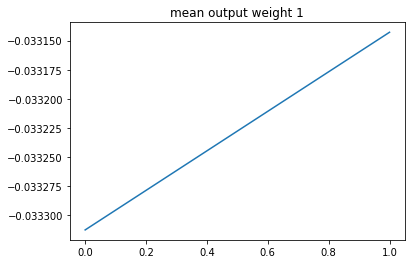

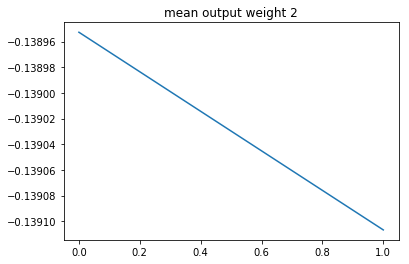

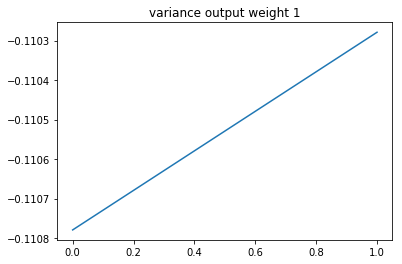

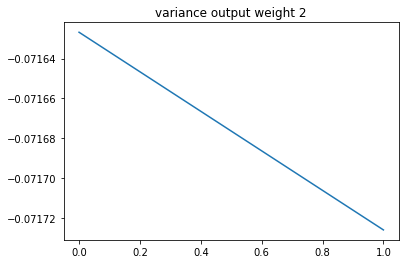

In [23]:
from graph_utils import *

df = pd.read_csv("1575743846.csv")


"""
w1_1,w1_2,w2_1,w2_2,
w1_1_grad,w1_2_grad,w2_1_grad,w2_2_grad,
b_1,b_2,
b_1_grad,b_2_grad
"""

graphCols(df, cols=['w1_1', 'w1_2', 'w2_1', 'w2_2'], ylabel='y', plotDim1=4, plotDim2=4)



In [ ]:
a = torch.normal(torch.tensor([0.0]*5), torch.tensor([5.0]*5))
print(a)

sig = nn.Sigmoid()
sig(a) > 0.5

bnn.likelihood_est(torch.tensor([0.0]*5), a, 0.1)

In [ ]:
for _ in range(10):
    pred1 = X_train @ W + b 
    pred2 = X_train @ W + b + np.random.normal(loc=0, scale=np.exp(X_train @ W_s + b_s))
    mae1 = np.mean(np.abs(pred1 - y_train))
    mae2 = np.mean(np.abs(pred2 - y_train))
    print("MAE 1: ", mae1, "MAE 2:", mae2)

In [ ]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

final_pred = bnn.model.forward(torch.Tensor(X_train))
print(final_pred[:5,0])


pred_std = torch.exp(final_pred[:,1])

print(pred_std)
print(X_train)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(311, projection='3d')

sparse_cap = int(len(X_train) / 10)

ax.scatter(X_train[:sparse_cap,0], X_train[:sparse_cap,1], pred_std[:sparse_cap].detach().numpy())
ax.set_xlabel('X_train[:,0]')
ax.set_ylabel('X_train[:,1]')
ax.set_zlabel('output[:,1] (Standard Deviation)')



# 2D Plot:
ax_2d_x = fig.add_subplot(312)
ax_2d_x.scatter(X_train[:,0], pred_std.detach().numpy())
ax_2d_x.set_xlabel('X_train[:,0]')
ax_2d_x.set_ylabel('output[:,1] (Standard Deviation)')


ax_2d_y = fig.add_subplot(313)
ax_2d_y.scatter(X_train[:,1], pred_std.detach().numpy())
ax_2d_y.set_xlabel('X_train[:,1]')
ax_2d_y.set_ylabel('output[:,1] (Standard Deviation)')



In [ ]:
np.zeros(40)
X_sample = np.vstack([np.zeros(21), np.array(list(range(-10,11)))]).T
X_sample = torch.tensor(np.array(X_sample), dtype=torch.float32)


predictions = bnn.model.forward(torch.Tensor(X_train))

sample_pred = bnn.model.forward(X_sample)

y_pred = sample_pred[:,0].detach().numpy()
std_pred = torch.exp(sample_pred[:,1]).detach().numpy()
log_s_pred = sample_pred[:,1].detach().numpy()

print(std_pred)

# Sample variance to add to the y predictions
std_array = []
for scale in std_pred:
  std_array.append(np.random.normal(loc=0, scale=np.exp(scale)))
std_array = np.array((std_array))



"""
plt.scatter(X_train[:,0], y_pred + std_array, alpha=.1, label='predicted')
plt.scatter(X_train[:,0], y_train, alpha=.1, label='real')
plt.title("Y hat and Y values across X1")
plt.legend()
plt.savefig("x1_y.png")
"""


plt.show()

# For constant std dev#
#std_pred = 10 * torch.ones([y_pred.shape[0]], dtype=torch.float64)
# For constant std dev#

#plt.scatter(X_train[:,1], y_pred + std_array, alpha=.1, label='predicted')
#plt.scatter(X_sample[:,1], y_pred, alpha=.1, label='predicted')
plt.errorbar(X_sample[:,1], y_pred, yerr=(std_pred), fmt='o', label='predicted')
plt.scatter(X_train[:,1], y_train, alpha=.1, c='C1', label='real')
plt.ylabel("Y")
plt.xlabel("X")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.title("Predicted and real Y values vs X")
plt.legend()
plt.savefig("x_y1.png")
plt.show()



#stds = []
#Xs = list(range(-10, 11))
#for x in Xs:
#    stds.append(x + b_s)

#std_pred = predictions[:,1].detach().numpy()

real_std = []
for x in range(-10, 11):
    real_std.append(np.exp(np.array([0, x] @ W_s + b_s)))
print(real_std)
# plt.plot(list(range(-10,11)), list(range(0, 21)), c='C3', label='real')
plt.plot(list(range(-10,11)), real_std, c='C3', label='real')
plt.plot(X_sample[:,1], (std_pred), label='predicted')
plt.title("Standard Deviation versus X value")
plt.ylabel("standard deviation")
plt.xlabel("X")
plt.legend()
plt.savefig("std1.png")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.show()

In [ ]:
print(torch.exp(bnn.model.l1.W_log_s_DO))

In [ ]:

plt.plot([i for i in range(100)], loss_by_epoch)

In [ ]:
a = torch.tensor([3,3,3])
b = torch.tensor([5,5,3])
a == b